In [1]:
import torch
import torch.nn as nn
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [4]:
dataset_path = './dataset'
dataset = datasets.ImageFolder(root = dataset_path,transform=image_transforms)

In [5]:
len(dataset)

2300

In [6]:
n_classes = len(dataset.classes)

In [7]:
train_size = int(0.75 * len(dataset))
train_size

1725

In [8]:
val_size = len(dataset) - train_size

In [9]:
from torch.utils.data import random_split
train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

In [10]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

In [11]:
for images,labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [12]:
images[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


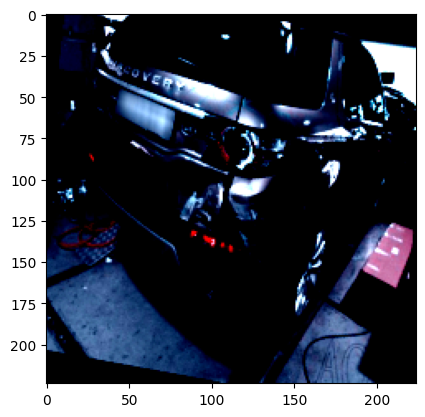

In [13]:
plt.imshow(images[31].permute(1,2,0))

In [13]:
class CarClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,6)
            )
    
    def forward(self,x):
        x = self.network(x)
        return x
        

In [12]:
model = CarClassifier().to(device)

In [13]:
crietrion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [14]:
print(len(train_loader))

54


In [15]:
#explaination of torch.max 
x = torch.tensor([[12,10,11],[9,-3,5]])
values,indices = torch.max(x.data,1)
print(values,indices)

tensor([12,  9]) tensor([0, 0])


In [14]:
import time

In [15]:
def train_model(model,criterion,optimizer,epochs=5):
    start = time.time()
    for epoch in range (epochs):
        running_loss = 0
        for images,labels in train_loader:
            images,labels = images.to(device),labels.to(device)

            optimizer.zero_grad()

            prediction = model(images)
            loss = criterion(prediction,labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} train loss {epoch_loss}" )
        
        total = 0
        correct = 0
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for images,labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                prediction = model(images)
                _,predicted = torch.max(prediction.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
            print(f"validation accuracy :{100*correct/total:.2f}%")
    end = time.time()
    print(f'run time {end - start}')
    return all_labels,all_predictions





In [40]:
all_labels,all_preds = train_model(model=model,criterion=crietrion,optimizer=optimizer,epochs=5)

Epoch 1 loss 1.2471681811191417
validation accuracy :52.52%
Epoch 2 loss 1.0601545450864014
validation accuracy :55.13%
Epoch 3 loss 0.9755486481719546
validation accuracy :57.22%
Epoch 4 loss 0.9399022493097517
validation accuracy :55.83%
Epoch 5 loss 0.8546916378868951
validation accuracy :58.43%
run time 262.2597999572754


# CNN with regularization

In [16]:
class CarClassifierRegularization(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,6)
            )
    
    def forward(self,x):
        x = self.network(x)
        return x
        

In [17]:
model = CarClassifierRegularization().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)




In [28]:
all_labels,all_preds = train_model(model=model,optimizer=optimizer,criterion=criterion,epochs=10)

Epoch 1 train loss 6.159216375262649
validation accuracy :35.48%
Epoch 2 train loss 1.3718440930048625
validation accuracy :47.13%
Epoch 3 train loss 1.237825271156099
validation accuracy :46.61%
Epoch 4 train loss 1.2077153755558863
validation accuracy :48.35%
Epoch 5 train loss 1.15618176151205
validation accuracy :49.22%
Epoch 6 train loss 1.1294370470223603
validation accuracy :49.91%
Epoch 7 train loss 1.0648482342561085
validation accuracy :50.61%
Epoch 8 train loss 1.1058270909168102
validation accuracy :51.48%
Epoch 9 train loss 1.104890861996898
validation accuracy :53.22%
Epoch 10 train loss 1.0404706917427204
validation accuracy :55.13%
run time 1451.3814668655396


In [18]:
class EfficientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        in_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features,6)
        )
    def forward(self,x):
        x = self.model(x)
        return x

In [19]:
model = EfficientNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=0.001)

In [39]:
train_model(model=model,criterion=criterion,epochs=10,optimizer=optimizer)

Epoch 1 train loss 1.4751457594059132
validation accuracy :51.65%
Epoch 2 train loss 1.1372527612580194
validation accuracy :55.13%
Epoch 3 train loss 1.0273384904419933
validation accuracy :57.22%
Epoch 4 train loss 0.9426711267895169
validation accuracy :62.43%
Epoch 5 train loss 0.9061209482175333
validation accuracy :61.57%
Epoch 6 train loss 0.8670776177335668
validation accuracy :60.52%
Epoch 7 train loss 0.8470770319302877
validation accuracy :61.91%
Epoch 8 train loss 0.8361696622989796
validation accuracy :63.30%
Epoch 9 train loss 0.7953156795766618
validation accuracy :62.26%
Epoch 10 train loss 0.827278834802133
validation accuracy :61.04%
run time 1064.951078414917


([3,
  5,
  2,
  2,
  5,
  1,
  2,
  4,
  1,
  1,
  2,
  1,
  3,
  0,
  4,
  1,
  4,
  0,
  5,
  1,
  5,
  1,
  0,
  2,
  1,
  4,
  2,
  2,
  0,
  2,
  2,
  3,
  0,
  2,
  2,
  0,
  4,
  3,
  0,
  0,
  5,
  5,
  2,
  2,
  2,
  5,
  0,
  5,
  0,
  2,
  0,
  2,
  5,
  0,
  0,
  0,
  2,
  0,
  4,
  0,
  0,
  2,
  5,
  3,
  1,
  4,
  0,
  0,
  2,
  4,
  1,
  3,
  5,
  0,
  3,
  2,
  4,
  5,
  1,
  0,
  0,
  2,
  4,
  0,
  0,
  2,
  5,
  2,
  0,
  2,
  0,
  2,
  0,
  2,
  1,
  4,
  1,
  2,
  2,
  4,
  2,
  1,
  2,
  2,
  0,
  2,
  5,
  0,
  3,
  2,
  1,
  1,
  0,
  0,
  5,
  2,
  2,
  1,
  4,
  5,
  5,
  3,
  1,
  0,
  3,
  2,
  0,
  1,
  1,
  2,
  5,
  3,
  2,
  3,
  5,
  0,
  3,
  1,
  1,
  5,
  5,
  5,
  2,
  0,
  1,
  5,
  3,
  2,
  1,
  2,
  4,
  3,
  2,
  5,
  3,
  4,
  5,
  4,
  3,
  0,
  3,
  0,
  0,
  2,
  2,
  5,
  2,
  2,
  1,
  0,
  2,
  3,
  0,
  3,
  0,
  2,
  1,
  5,
  0,
  2,
  3,
  5,
  2,
  2,
  1,
  5,
  1,
  0,
  0,
  2,
  3,
  5,
  0,
  1,
  5,
  3,
  2,
  1,
  3,
  3,


In [23]:
class ResnetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True
        
        self.model.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.model.fc.in_features,6)
        )

    def forward(self,x):
        x = self.model(x)
        return x


In [24]:
model = ResnetClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=0.0002)


In [22]:
labels,preds = train_model(model=model,optimizer=optimizer,criterion=criterion,epochs=10)

Epoch 1 train loss 0.9844717924241666
validation accuracy :69.39%
Epoch 2 train loss 0.5534791019227769
validation accuracy :72.87%
Epoch 3 train loss 0.4217565887504154
validation accuracy :74.61%
Epoch 4 train loss 0.3993675385912259
validation accuracy :77.22%
Epoch 5 train loss 0.46499400392726614
validation accuracy :74.61%
Epoch 6 train loss 0.3436349221263771
validation accuracy :77.74%
Epoch 7 train loss 0.23304151105522006
validation accuracy :77.22%
Epoch 8 train loss 0.20825053372040944
validation accuracy :76.35%
Epoch 9 train loss 0.4221949606995892
validation accuracy :73.22%
Epoch 10 train loss 0.3628450455488982
validation accuracy :77.04%
run time 966.7784790992737


# Training with params obtained from hyper parameter tuning

In [25]:
model = ResnetClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p:p.requires_grad,model.parameters()),lr=0.0002)

In [26]:
labels,preds = train_model(model=model,optimizer=optimizer,criterion=criterion,epochs=10)

Epoch 1 train loss 1.193212854641455
validation accuracy :70.43%
Epoch 2 train loss 0.5410579923126433
validation accuracy :74.61%
Epoch 3 train loss 0.34058175208391966
validation accuracy :77.57%
Epoch 4 train loss 0.19999311346974638
validation accuracy :76.35%
Epoch 5 train loss 0.15150355940891636
validation accuracy :77.91%
Epoch 6 train loss 0.11535192570752567
validation accuracy :77.04%
Epoch 7 train loss 0.07575645927270805
validation accuracy :78.09%
Epoch 8 train loss 0.05518842441098833
validation accuracy :76.52%
Epoch 9 train loss 0.0721373013910596
validation accuracy :77.39%
Epoch 10 train loss 0.07693797633638261
validation accuracy :81.57%
run time 622.1349005699158


In [27]:
labels[:5],preds[:5]

([5, 5, 4, 5, 0], [5, 5, 5, 5, 0])

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(labels,preds)


'              precision    recall  f1-score   support\n\n           0       0.87      0.85      0.86       122\n           1       0.70      0.80      0.75        92\n           2       0.94      0.89      0.91       134\n           3       0.80      0.81      0.80        73\n           4       0.75      0.68      0.71        80\n           5       0.77      0.80      0.78        74\n\n    accuracy                           0.82       575\n   macro avg       0.80      0.80      0.80       575\nweighted avg       0.82      0.82      0.82       575\n'

In [29]:
print(report)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       122
           1       0.70      0.80      0.75        92
           2       0.94      0.89      0.91       134
           3       0.80      0.81      0.80        73
           4       0.75      0.68      0.71        80
           5       0.77      0.80      0.78        74

    accuracy                           0.82       575
   macro avg       0.80      0.80      0.80       575
weighted avg       0.82      0.82      0.82       575



In [35]:
class_names = dataset.classes

In [36]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import numpy as np
cm = confusion_matrix(labels,preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
cm

array([[104,  17,   1,   0,   0,   0],
       [ 11,  74,   7,   0,   0,   0],
       [  2,  12, 119,   0,   0,   1],
       [  2,   1,   0,  59,   8,   3],
       [  0,   1,   0,  11,  54,  14],
       [  0,   1,   0,   4,  10,  59]], dtype=int64)

Text(50.58159722222221, 0.5, 'True')

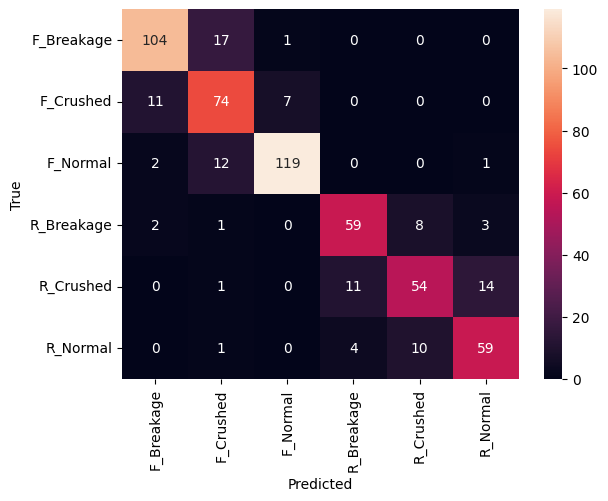

In [42]:
import seaborn as sns
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

In [43]:
torch.save(model.state_dict(),'saved_model.pth')